<a href="https://colab.research.google.com/github/Justinezgh/muse/blob/u%2FJustinezgh%2Fdev/notebooks/Draft_Inference_LogNornalField_MUSE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports

In [2]:
!pip install --quiet git+https://github.com/marius311/muse_inference.git
!pip install --quiet git+https://github.com/Justinezgh/muse.git
!pip install --quiet chainconsumer
!pip install --quiet numpyro

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 292.7/292.7 KB 15.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 287.4/287.4 KB 33.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.5/43.5 KB 5.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


In [3]:
%pylab inline 
import muse_inference
from muse_inference.jax import JaxMuseProblem
from muse_inference import MuseResult
import numpyro
from numpyro.handlers import seed, condition, trace
import numpyro.distributions as dist
import jax
import jax.numpy as jnp
from jax.scipy.linalg import toeplitz
import tensorflow_probability as tfp; tfp = tfp.substrates.jax
tfd= tfp.distributions
from chainconsumer import ChainConsumer
import arviz as az

Populating the interactive namespace from numpy and matplotlib


# Config

In [4]:
# Set the seed for reproducibility
#seed = 123456

Lside       = 20
alpha       = 1
beta        = 0.5
PixelNoise  = 0.5

# Setup for correlation function
nbin        = 4*Lside
ndata       = 4*Lside
rmax        = Lside * jnp.sqrt(2)

# Set number of simulations for summary-based inference
nsims        = 500

# Set ranges
nalpha       = 80
nbeta        = nalpha

alphamin     = 0.
alphamax     = 2.
betamin      = 0.2
betamax      = 0.8

# Set contour levels for plots (from Numerical Recipes 15.6)
contour_levels = [-11.8/2, -6.17/2, -2.30/2, 0]

# Models

## Florent's code 

In [ ]:
# Define a log_normal field class

class LogNormalField:
    @staticmethod
    def compute_rsquared(nside):
        """
        Compute the correlation function of the underlying gaussian field
        
        Parameters:
            nside : int
                Image is nside x nside pixels
        """
        import numpy as np
        from scipy.linalg import toeplitz
        
        _Di = np.tile(toeplitz(np.arange(nside)),(nside,nside))
        _Dj = np.concatenate(
                            [np.concatenate(
                                            [np.tile(np.abs(i-j),(nside,nside)) for i in range(nside)],
                                            axis=0)
                            for j in range(nside)],axis=1)
        _distance_squared = _Di*_Di+_Dj*_Dj
        
        return _distance_squared

    # The lognormal correlation function where the gaussian field has a gaussian power spectrum,
    # and the gaussian correlation function xi_G.

    @staticmethod
    def xi_G(rsq, beta):
        """
        Calculates the two-point correlation function of a gaussian field with gaussian power spectrum
        
        Parameters:
        
        rsq : float
            separation^2
        beta  : float
            Gaussian smoothing width of gaussian field
        """
        import numpy as np
        
        xi = np.exp(-0.25*rsq/(beta**2))
            
        return xi

    @staticmethod
    def xi_LN(r, beta, alpha, PixelNoise):
        """
        Calculates the lognormal two-point correlation function
        
        Parameters:
        
        r : float
            Pair separation
        beta  : float
            Gaussian smoothing width of underlying gaussian field
        alpha : float
            Nongaussianity parameter in lognormal transformation
        PixelNoise : float
            Standard deviation of added noise per pixel
        """
        import numpy as np
        
        xi = 1/(np.power(alpha+1e-12,2)) * (np.exp(np.power(alpha,2)*np.exp(-0.25*np.power(r/beta,2))) - 1)
        
        # Add pixel noise at zero separation:
        
        xi[np.where(r<1e-5)] += PixelNoise**2
        
        return xi
    
    @staticmethod
    def dxi_LN_dalpha(r, beta, alpha, PixelNoise):
        import numpy as np
        
        return 2/(alpha+1e-12) * np.exp(-0.25*np.power(r/beta,2)) * np.exp(np.power(alpha,2)*np.exp(-0.25*np.power(r/beta,2))) - 2/np.power(alpha+1e-12,3) * (np.exp(np.power(alpha,2)*np.exp(-0.25*np.power(r/beta,2))) - 1)
    
    @staticmethod
    def dxi_LN_dbeta(r, beta, alpha, PixelNoise):
        import numpy as np
        
        return (0.5*np.power(r,2)/np.power(beta,3)) * np.exp(-0.25*np.power(r/beta,2)) * np.exp(np.power(alpha,2)*np.exp(-0.25*np.power(r/beta,2)))

    def __init__(self,Lside,rmax,nbin):
        """
        
        Parameters:
            rmax : float
                Maximum pair separation considered
            nbin : int
                Number of bins for shell-averaged correlation function
        """
        import numpy as np
        
        self.rmax       = rmax
        self.nbin       = nbin
        self.Lside      = Lside

        # compute the separations and indices on a grid
        self.rsq        = self.compute_rsquared(Lside)
        self.r          = np.sqrt(self.rsq)
        self.bins       = np.arange(nbin)*rmax/nbin
        self.index      = np.digitize(self.r,self.bins)
        self.average_r  = np.array([self.r[self.index == n].mean() for n in range(nbin) if np.sum(self.index == n)>0])
    
    @staticmethod
    def G_to_LN(gaussian, alpha):
        import numpy as np
        
        # Make lognormal (variance of gaussian field is unity by construction)
        # Divide by 1/alpha so that the signal-to-noise ratio is independent of alpha
        return 1/alpha * (np.exp(alpha * gaussian-0.5*alpha**2)-1)
    
    def run_simulation(self, alpha, beta, PixelNoise):
        """
        Create a lognormal field from a gaussian field with a Gaussian correlation function
        """
        import numpy as np
        
        Lside      = self.Lside
        rsq        = self.rsq
        
        # Compute the Gaussian correlation function
        xiG  = self.xi_G(rsq, beta)
        
        # Compute the Gaussian random field
        field = (np.random.multivariate_normal(np.zeros(Lside*Lside),xiG)).reshape(Lside,Lside)
        
        # Make lognormal (variance of gaussian field is unity by construction)
        field = self.G_to_LN(field, alpha)
        
        # Add noise
        field += np.random.normal(loc=0.0,scale=PixelNoise,size=(Lside,Lside))
        
        return field
    
    def pymc3_model(self, field_data, alphamin, alphamax, betamin, betamax, PixelNoise):
        import numpy as np
        import pymc as pm
        LN_model = pm.Model()
        
        Lside              = self.Lside
        rsq                = self.rsq
        zero               = np.zeros(Lside*Lside)
        PixelNoiseVector   = PixelNoise*np.ones(Lside*Lside)
        InvNoiseCovariance = np.diag(1/(PixelNoiseVector**2))
        field_data         = field_data.reshape(Lside*Lside)

        with LN_model:

            # Uniform priors for unknown model parameters (alpha,beta):

            alpha_p   = pm.Uniform("alpha", lower=alphamin, upper=alphamax)
            beta_p    = pm.Uniform("beta",  lower=betamin,  upper=betamax)

            # Compute (beta-dependent) gaussian field correlation function:

            xi = pm.math.exp(-0.25*rsq/(beta_p*beta_p))

            # Gaussian field values are latent variables:
            gaussian = pm.MvNormal("gaussian",mu=zero,cov=xi,shape=Lside*Lside)

            # Expected value of lognormal field, for given (alpha, beta, gaussian):

            muLN = 1/alpha_p * (pm.math.exp(alpha_p * gaussian-0.5*alpha_p*alpha_p)-1)

            # Likelihood (sampling distribution) of observations, given the mean lognormal field:

            Y_obs = pm.MvNormal("Y_obs", mu=muLN, tau=InvNoiseCovariance, observed=field_data)
        
        return LN_model
    
    def run_diff_simulation(self, alpha, beta, PixelNoise, step, seed):
        """
        Run simulations for finite differencing
        """
        import numpy as np
        from scipy.stats import multivariate_normal
        
        Lside      = self.Lside
        rsq        = self.rsq
        
        alphap     = alpha*(1+step)
        alpham     = alpha*(1-step)
        betap      = beta*(1+step)
        betam      = beta*(1-step)
        
        # Compute the gaussian correlation function
        xiG  = self.xi_G(rsq,beta)
        xiG_betap = self.xi_G(rsq,betap)
        xiG_betam = self.xi_G(rsq,betam)
        
        # Compute Gaussian random fields with the same phases
        Gfield = multivariate_normal(mean=np.zeros(Lside*Lside), cov=xiG).rvs(random_state=seed).reshape(Lside,Lside)
        Gfield_betap = multivariate_normal(mean=np.zeros(Lside*Lside), cov=xiG_betap).rvs(random_state=seed).reshape(Lside,Lside)
        Gfield_betam = multivariate_normal(mean=np.zeros(Lside*Lside), cov=xiG_betam).rvs(random_state=seed).reshape(Lside,Lside)
        
        # Make lognormal (variance of gaussian field is unity by construction)
        field = self.G_to_LN(Gfield, alpha)
        field_betap = self.G_to_LN(Gfield_betap, alpha)
        field_betam = self.G_to_LN(Gfield_betam, alpha)
        field_alphap = self.G_to_LN(Gfield, alphap)
        field_alpham = self.G_to_LN(Gfield, alpham)
        
        # Add noise
        noise = np.random.normal(loc=0.0,scale=PixelNoise,size=(Lside,Lside))
        field += noise
        field_betap += noise
        field_betam += noise
        field_alphap += noise
        field_alpham += noise
        
        return field, field_alphap, field_alpham, field_betap, field_betam
    
    def compute_corrfn(self,field):
        """
        Compute two-point correlation function
        """       
        import numpy as np
        
        index    = self.index
        nbin     = self.nbin
        
        # compute the correlations
        correlations = np.outer(field,field)
        corrfn = np.array([correlations[index==n].mean() for n in range(nbin) if len(correlations[index==n])>0])
        
        return corrfn
    
    def compute_corrfn_derivatives(self, field, field_alphap, field_alpham, field_betap, field_betam, step):
        """
        Compute derivatives of the two-point correlation function
        """
        
        # Compute correlation functions
        corrfn         = self.compute_corrfn(field)
        corrfn_dalphap = self.compute_corrfn(field_alphap)
        corrfn_dalpham = self.compute_corrfn(field_alpham)
        corrfn_dbetap  = self.compute_corrfn(field_betap)
        corrfn_dbetam  = self.compute_corrfn(field_betam)
        
        # Compute derivatives by second-order central finite differences
        dcorrfn_dalpha = (corrfn_dalpham - 2*corrfn + corrfn_dalphap)/(step**2)
        dcorrfn_dbeta  = (corrfn_dbetam  - 2*corrfn + corrfn_dbetap )/(step**2)
        
        return dcorrfn_dalpha, dcorrfn_dbeta
    
    def covariance(self,fields):
        """
        Compute covariance from a number of fields
        
        Parameter:
            fields : int
                lognormal field objects contributing to the covariance matrix
        """
        import numpy as np
        
        nsims  = len(fields)
        nbins  = self.nonzerobins
        
        print('Number of simulations',nsims)
        print('Number of non-zero pair bins',nbins)
        
        corrfns = np.array([fields[i]['corrfn'] for i in range(nsims)])
        meanxi = np.mean(corrfns,axis=0)
        covxi = np.cov(corrfns.T)
        
        return meanxi, covxi
    
    # Utility properties
    @staticmethod
    def var_th(alpha, PixelNoise):
        import numpy as np
        return 1/np.power(alpha+1e-12,2)*(np.exp(alpha**2)-1)+PixelNoise**2
    @staticmethod
    def skew_th(alpha):
        import numpy as np
        return (np.exp(alpha**2)+2)*np.sqrt(np.exp(alpha**2)-1)
    @staticmethod
    def dskew_dalpha(alpha):
        import numpy as np
        return 2*alpha*np.exp(alpha**2) * ( np.sqrt(np.exp(alpha**2)-1) - 0.5*(np.exp(alpha**2)+2)/(np.sqrt(np.exp(alpha**2)-1)) )
    @staticmethod
    def kurtosis_th(alpha):
        import numpy as np
        return np.exp(4*alpha**2)+2*np.exp(3*alpha**2)+3*np.exp(2*alpha**2)-6
    @staticmethod
    def dkurtosis_dalpha(alpha):
        import numpy as np
        return 8*alpha*np.exp(4*alpha**2)+6*alpha*np.exp(3*alpha**2)+6*alpha*np.exp(2*alpha**2)
    @staticmethod
    def max(field):
        import numpy as np
        return np.max(field)
    @staticmethod
    def min(field):
        import numpy as np
        return np.min(field)
    @staticmethod
    def var(field):
        import numpy as np
        return np.var(field)
    @staticmethod
    def mean(field):
        import numpy as np
        return np.mean(field)
    @staticmethod
    def skew(field):
        from scipy.stats import skew
        return skew(field.flatten())
    @staticmethod
    def kurtosis(field):
        from scipy.stats import kurtosis
        return kurtosis(field.flatten())
    
    # xi has empty bins removed.  Note the number of non-empty elements
    @property
    def nonzerobins(self):
        return len(self.average_r)
    
    @property
    def dt(self):
        import numpy as np
        return np.dtype([('field', np.float, (self.Lside,self.Lside)), ('corrfn', np.float, (self.nonzerobins))])
# end class LogNormalField


# Summary statistics: infer alpha and beta.  Use Sellentin-Heavens likelihood.

def lnL_LN(LN,alpha,beta,xi,invcov,nsims,PixelNoise):
    """
    Compute the ln likelihood
    
    Parameters:
        LN : LogNormalField instance
            log-normal field setup
        alpha : float
            nongaussianity parameter in lognormal model
        beta  : float
            width of gaussian correlation function
        xi : float array
            two-point correlation function (the data)
        invcov : float matrix
            Inverse covariance matrix of the data (ndata x ndata)
        nsims : int
            Number of simulations used to estimate the covariance matrix
        PixelNoise : float
            Standard deviation of added noise per pixel
    """
    
    ave_r   = LN.average_r
    ndata   = LN.nonzerobins
    ndatax  = xi.size
    ndatac1 = invcov.shape[0]
    ndatac2 = invcov.shape[1]
    
    assert ndata == ndatax
    assert ndata == ndatac1
    assert ndata == ndatac2
    
    if(alpha<0):
        return -np.inf
    
    data = xi
    invC = invcov
    
    theory = LN.xi_LN(ave_r,beta,alpha,PixelNoise)
    
    lnLike_SH   = Sellentin_Heavens(data,theory,invC,nsims)
    
    return lnLike_SH

def Sellentin_Heavens(data,theory,invC,nsims):
    """
    Compute the Sellentin-Heavens likelihood (Sellentin & Heavens 2016)
    
    Parameters:
        data : float (array of size N)
            data vector (xi, in this case)
        theory : float (array of size N)
            theory vector
        invC : float (N x N)
            inverse covariance matrix
        nsims : int
            Number of simulations used to estimate the covariance matrix        
    """
        
    diff   = data-theory
    chisq  = np.dot(diff,np.dot(invC,diff))
    
    lnL_SH =  -0.5*nsims*np.log(1+chisq/(nsims-1)) 
    
    return lnL_SH

## Create the numpyro model and simulate LogNormal maps 

We have nsims maps for alpha = 1 and beta = 0.5



In [5]:
from muse_exp.simulators.toy_log_normal_numpyro_version import  ToyLogNormal

model = ToyLogNormal(
    Lside=Lside, 
    PixelNoise=PixelNoise, 
    alpha_min=alphamin, 
    alpha_max=alphamax, 
    beta_min=betamin, 
    beta_max=betamax
).numpyro_model

In [6]:
from numpyro.handlers import seed
@jax.vmap
@jax.jit
def get_samples(key):
  
  model_cond = condition(model, {'alpha': alpha, 'beta': beta})
  cond_model = seed(model_cond, key)
  model_trace = trace(cond_model).get_trace()
  sample = {
      'theta':
      jnp.stack(
          [model_trace['alpha']['value'], model_trace['beta']['value']],
          axis=-1),
      'y':
      model_trace['y']['value'],
      'z':
      model_trace['z']['value']
  }

  return sample

simulations = get_samples(jax.random.split(jax.random.PRNGKey(0), nsims))

In [7]:
m_data = simulations['y'][0]

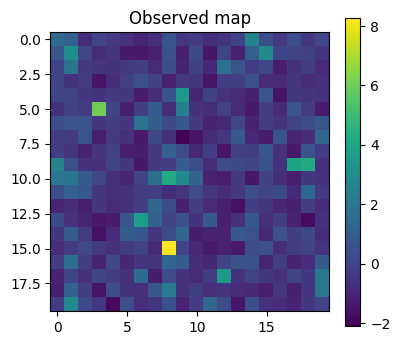

In [8]:
figure(figsize=(4,4))
imshow(m_data); colorbar(fraction=0.05);
title('Observed map')
savefig('m_data_amount_of_ng%s.pdf' % alpha)

/usr/local/lib/python3.9/dist-packages/arviz/stats/density_utils.py:957: NumbaWarning: 
Compilation is falling back to object mode WITH looplifting enabled because Function "histogram" failed type inference due to: non-precise type pyobject
During: typing of argument at /usr/local/lib/python3.9/dist-packages/arviz/stats/density_utils.py (979)

File "../usr/local/lib/python3.9/dist-packages/arviz/stats/density_utils.py", line 979:
def histogram(data, bins, range_hist=None):
    <source elided>
    """
    hist, bin_edges = np.histogram(data, bins=bins, range=range_hist)
    ^

  @conditional_jit(cache=True)
/usr/local/lib/python3.9/dist-packages/numba/core/object_mode_passes.py:151: NumbaWarning: Function "histogram" was compiled in object mode without forceobj=True.

File "../usr/local/lib/python3.9/dist-packages/arviz/stats/density_utils.py", line 958:
@conditional_jit(cache=True)
def histogram(data, bins, range_hist=None):
^

  warnings.warn(errors.NumbaWarning(warn_msg,
/usr/local/l

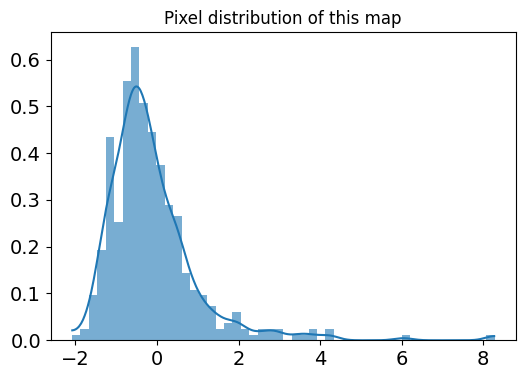

In [9]:
figure(figsize=(6,4))
hist(simulations['y'][0].reshape([-1]), 50, density = True, alpha = 0.6);
az.plot_kde(simulations['y'][0].reshape([-1]))

title('Pixel distribution of this map')
savefig('pixel_dist_amount_of_ng%s.pdf' % alpha)

### Tests

Just checking that the numpyro model is ok

In [10]:
from tqdm import tqdm

LN=LogNormalField(Lside, rmax, nbin)

# Create a list of lognormal field objects and compute their correlation functions:
lognormfields = []

for sim in tqdm(simulations['y']):

    cor = LN.compute_corrfn(sim)
    lognormfields.append(np.array((sim, cor), dtype=LN.dt))

lognormfields=np.array(lognormfields)

NameError: ignored

In [ ]:
# Compute the mean correlation function from the list of LN field objects, and its covariance
mean2pt, cov = LN.covariance(lognormfields)

# Compute the theory
xiLN = LN.xi_LN(LN.average_r, beta, alpha, PixelNoise)

In [ ]:
# Plot the correlation function

figure(figsize=(6,4))
xlabel('$r$',fontsize=15)
ylabel('$\\xi(r)$',fontsize=15)
ylim([-1.5,3])

for i in range(nsims):
    plot(
      LN.average_r, 
      lognormfields[i]['corrfn'], 
      color="grey", 
      alpha=0.5, 
      zorder=0.5
    )

# Plot the mean correlation function:
plot(LN.average_r, mean2pt, lw=2.5, label="Simulations")

# Plot the diagonal of the covariance matrix. 
# Wild fluctuations are from varying numbers of pairs per bin
fill_between(
    LN.average_r,
    mean2pt - 2 * np.sqrt(np.diag(cov)), 
    mean2pt + 2 * np.sqrt(np.diag(cov)),
    alpha=0.5
)
plot(LN.average_r, mean2pt - 2 * np.sqrt(np.diag(cov)), c='C0', lw=1.)
plot(LN.average_r, mean2pt + 2 * np.sqrt(np.diag(cov)), c='C0', lw=1.)

# Plot the mean correlation function and the theory with the correct alpha, beta :
plot(LN.average_r, xiLN, ls='--', lw=2.5, label="Theory")

legend(fontsize=15)
savefig('power_spectrum_amount_of_ng%s.pdf' % alpha)

# Full field inference

## Numpyro version

In [ ]:
from numpyro.handlers import seed, condition, reparam
from numpyro.infer.reparam import LocScaleReparam


observed_model = condition(model, {'y': m_data})
nuts_kernel = numpyro.infer.NUTS(
    observed_model,
    init_strategy=numpyro.infer.init_to_median,
    max_tree_depth=6,
    step_size=0.1
)

mcmc = numpyro.infer.MCMC(
    nuts_kernel,
    num_warmup=200,
    num_samples=10000,
    progress_bar=True
) 

mcmc.run(jax.random.PRNGKey(0))
samples = mcmc.get_samples()

sample: 100%|██████████| 10200/10200 [15:20<00:00, 11.08it/s, 63 steps of size 1.10e-01. acc. prob=0.88]


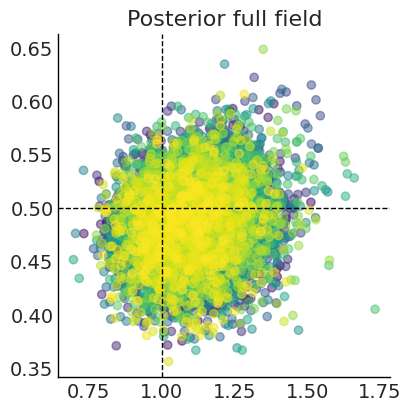

In [ ]:
figure(figsize=(4,4))

plt.scatter(
    samples['alpha'], 
    samples['beta'],
    c= arange(len(samples['alpha'])), 
    alpha = 0.5
)

axvline(alpha, lw=1, ls="--", color="k")
axhline(beta, lw=1, ls="--", color="k")

title('Posterior full field')
savefig('full_field_posterior_amount_of_ng%s.pdf' % alpha)

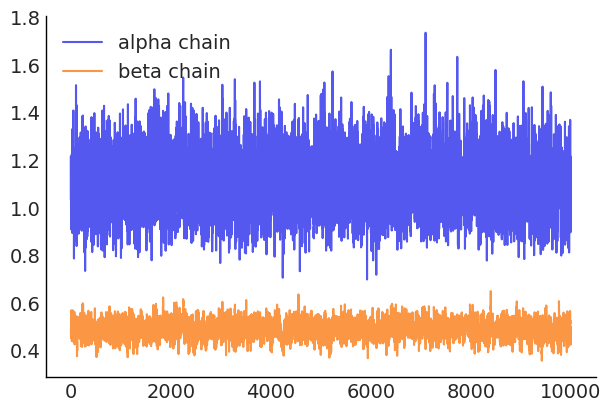

In [ ]:
figure(figsize=(6,4))
plot(samples['alpha'], alpha = 0.8, label = 'alpha chain')
plot(samples['beta'], alpha = 0.8, label = 'beta chain')
legend()
savefig('full_field_chains_amount_of_ng%s.pdf' % alpha)

In [1]:
from numpyro.handlers import seed, condition, reparam
from numpyro.infer.reparam import LocScaleReparam

 
observed_model = condition(model, {'y': m_data, 'omega_c': 0.3, 'sigma_8': 0.8})
nuts_kernel = numpyro.infer.NUTS(
    observed_model,
    init_strategy=numpyro.infer.init_to_median,
    max_tree_depth=6,
    step_size=0.1
)

mcmc = numpyro.infer.MCMC(
    nuts_kernel,
    num_warmup=200,
    num_samples=10000,
    progress_bar=True
) 

mcmc.run(jax.random.PRNGKey(0))
samples = mcmc.get_samples()

ModuleNotFoundError: ignored

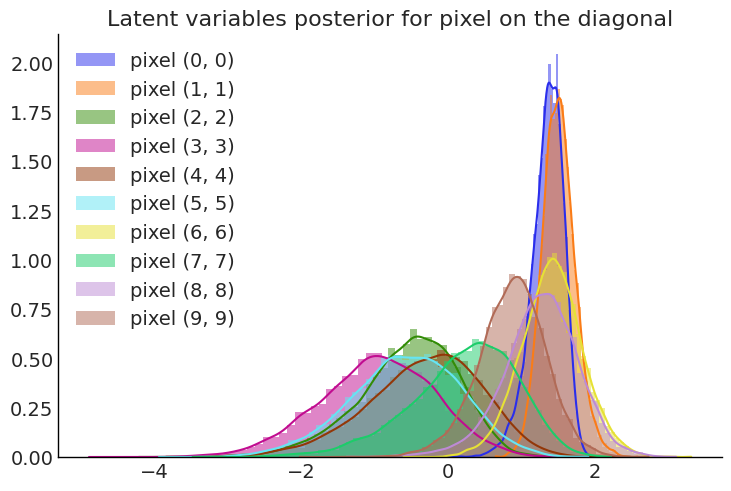

In [ ]:
for pix in range(10):
  hist(samples['z'].reshape([-1, Lside, Lside])[:,pix,pix], 60, alpha = 0.5, density = True, label ='pixel (%d, %d)' % (pix, pix))
  az.plot_kde(samples['z'].reshape([-1, Lside, Lside])[:,pix,pix], plot_kwargs={"c":'C%d'%pix})
  title('Latent variables posterior for pixel on the diagonal')
  legend()
  
savefig('posterior_z_distribution_diag_%s.pdf' % (alpha))

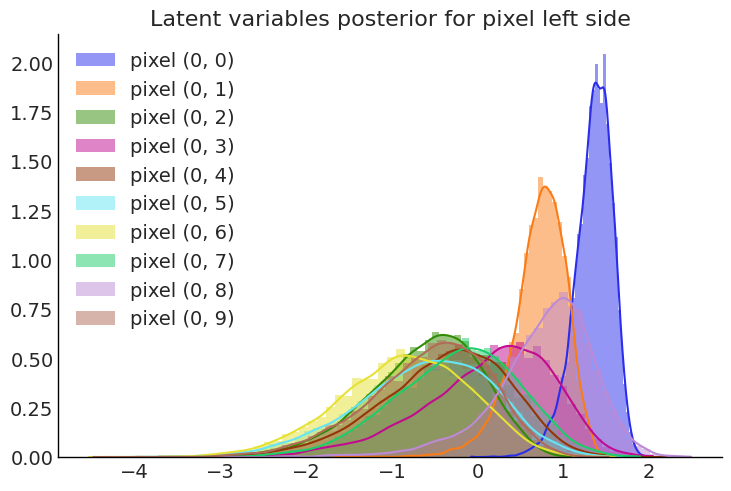

In [ ]:
pix1 = 0 

for pix in range(10):
  hist(samples['z'].reshape([-1, Lside, Lside])[:,pix1,pix], 60, alpha = 0.5, density = True, label ='pixel (%d, %d)' % (pix1, pix))
  az.plot_kde(samples['z'].reshape([-1, Lside, Lside])[:,pix1,pix], plot_kwargs={"c":'C%d'%pix})
  title('Latent variables posterior for pixel left side')
  legend()
  
savefig('posterior_z_distribution_side_%s.pdf' % (alpha))

In [51]:
(5 * 60 / 128)**2

5.4931640625

In [53]:
5.5 / 180 * jnp.pi

0.09599310885968812

## Florent's version 

In [ ]:
# !pip install --quiet pymc

In [ ]:
# import pymc as pm

In [ ]:
# # Sampler setup
# nsamples = 10000
# ntune = 300
# ncores = 16
# target_accept = 0.80
# init = 'advi'

# # Import pymc3 lognormal model from the LN library
# LN_for_mcmc = LN.pymc3_model(
#     m_data,
#     alphamin,
#     alphamax,
#     betamin,
#     betamax,
#     PixelNoise
# )

In [ ]:
# with LN_for_mcmc:
#     trace_pymc = pm.sample(
#         nsamples, 
#         tune=ntune, 
#         cores=ncores, 
#         target_accept=target_accept,           
#         init=init, 
#         discard_tuned_samples=False
#     )

array([[<Axes: title={'center': 'gaussian'}>,
        <Axes: title={'center': 'gaussian'}>],
       [<Axes: title={'center': 'alpha'}>,
        <Axes: title={'center': 'alpha'}>],
       [<Axes: title={'center': 'beta'}>,
        <Axes: title={'center': 'beta'}>]], dtype=object)

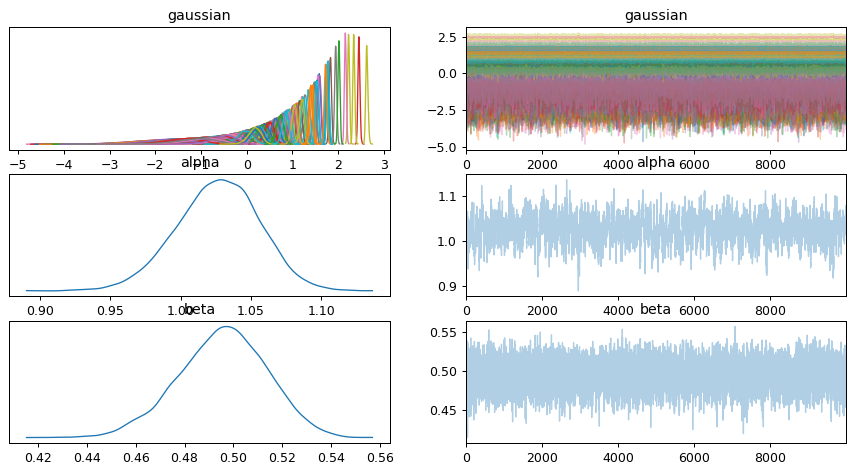

In [ ]:
# # Plot the traces
# pm.plot_trace(trace_pymc)

In [ ]:
# trace_pymc.to_netcdf("pymc_trace.nc")

'pymc_trace.nc'

In [ ]:
# import arviz as az
# posterior = az.extract(trace_pymc)

In [ ]:
# posterior

<xarray.Dataset>
Dimensions:         (gaussian_dim_0: 400, sample: 10000)
Coordinates:
  * gaussian_dim_0  (gaussian_dim_0) int64 0 1 2 3 4 5 ... 395 396 397 398 399
  * sample          (sample) object MultiIndex
  * chain           (sample) int64 0 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0
  * draw            (sample) int64 0 1 2 3 4 5 ... 9994 9995 9996 9997 9998 9999
Data variables:
    gaussian        (gaussian_dim_0, sample) float64 1.548 1.615 ... 0.7454
    alpha           (sample) float64 1.018 0.9931 1.026 ... 1.068 1.06 1.058
    beta            (sample) float64 0.4921 0.5192 0.4941 ... 0.4745 0.48 0.4873
Attributes:
    created_at:                 2023-03-31T06:32:44.755684
    arviz_version:              0.15.1
    inference_library:          pymc
    inference_library_version:  5.1.2
    sampling_time:              11494.455133914948
    tuning_steps:               300

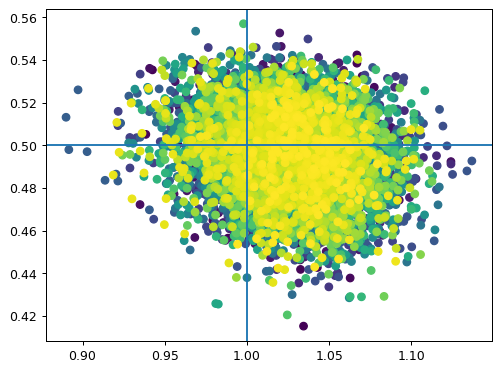

In [ ]:
# plt.scatter(
#     posterior['alpha'], 
#     posterior['beta'],
#     c= arange(len(samples['alpha'])), 
# )
# plt.axvline(alpha)
# plt.axhline(beta)

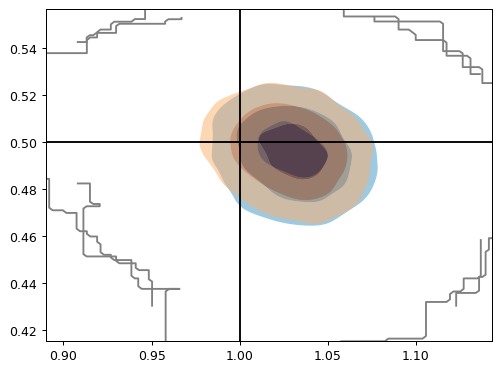

In [ ]:
# ax = az.plot_kde(
#     samples['alpha'], samples['beta'],
#     contour_kwargs={"levels":3, "levels": contour_levels}, 
#     contourf_kwargs={"levels":3, "cmap": "Blues"}, 
#     legend= True,
#     label='numpyro simulator', 
# );

# az.plot_kde(
#     posterior['alpha'], 
#     posterior['beta'],
#     contour_kwargs={"levels":3, "levels": contour_levels}, 
#     contourf_kwargs={"levels":3, "cmap": "Oranges", 'alpha':0.5},
#     label='F&A simulator',
#     legend=True
# );

# plt.axvline(alpha, c='black')
# plt.axhline(beta, c='black')


# Inference with summary statistics

In [ ]:
print('Condition number of covariance matrix =', np.linalg.cond(cov))

invcov   = np.linalg.inv(cov)
ave_r    = LN.average_r

print('ndata', ndata)
print('Max radius/pixel size', ave_r.max())

Condition number of covariance matrix = 2902.1198176079934
ndata 80
Max radius/pixel size 26.870057685088806


<Figure size 600x400 with 0 Axes>

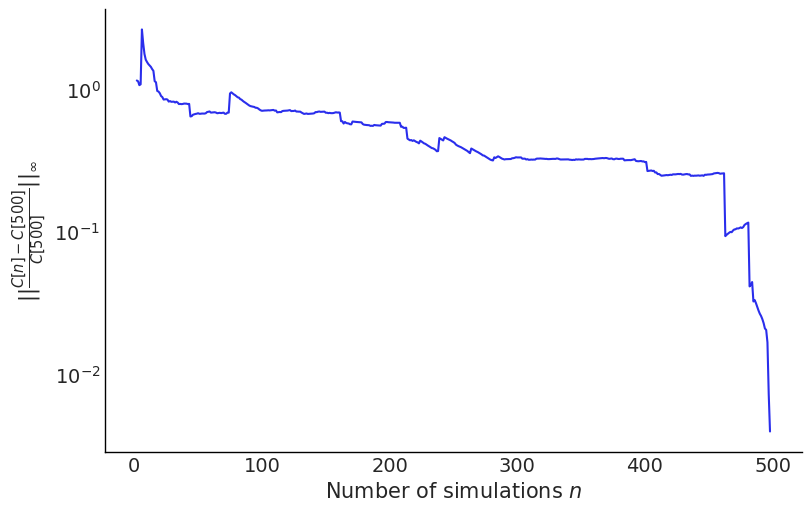

In [ ]:
# Plot convergence of the covariance matrix
figure(figsize=(6,4))
sims = np.array([lognormfields[n]['corrfn'] for n in range(nsims)])

cov_rel_error_inf = np.array([
    np.linalg.norm(
        cov-np.cov(sims[:n].T),
        ord=np.inf
    ) / np.linalg.norm(cov, ord=np.inf) for n in range(2,nsims-1)
])

fig = plt.figure(figsize=(8,5))
ax = fig.add_subplot(1,1,1)
ax.set_xlabel("Number of simulations $n$")
ax.set_ylabel(
    "$||\\frac{C[n]-C["+str(nsims)+"]}{C["+str(nsims)+"]}||_{\infty}$"
)
ax.semilogy(np.arange(2,nsims-1),cov_rel_error_inf)
savefig('covariance_cvg_amount_of_ng%s.pdf' % alpha)

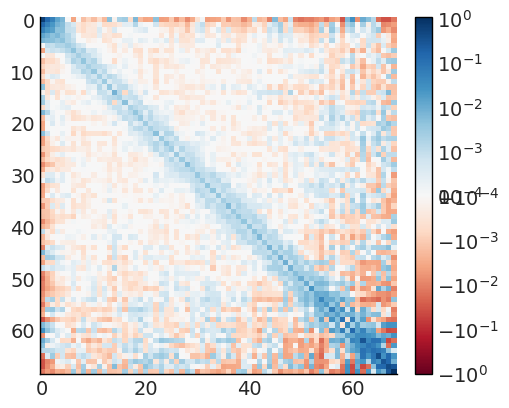

<Figure size 720x480 with 0 Axes>

In [ ]:
# Plot the covariance matrix
import matplotlib.colors as colors

figure(figsize=(5,5))
plt.pcolormesh(
    np.arange(len(cov)), 
    np.arange(len(cov)), 
    cov,
    norm=colors.SymLogNorm(
        linthresh=0.0001, 
        linscale=0.001,
        vmin=-cov.max(), 
        vmax=cov.max(), 
        base=10
    ),
    cmap='RdBu', 
    shading='auto'
)

plt.gca().invert_yaxis()
plt.gca().set_aspect('equal')
plt.colorbar(fraction=0.05)
plt.show()
savefig('covariance_matrix_amount_of_ng%s.pdf' % alpha)

In [ ]:
# Compute lnL on a grid

alphas  = np.linspace(alphamin+1e-3, alphamax, nalpha)
betas   = np.linspace(betamin, betamax, nbeta)
lnL     = np.zeros((nalpha, nbeta))


data = LN.compute_corrfn(simulations['y'][0]) 
lnL[:,:] = [[lnL_LN(
    LN, 
    alphas[ialpha],
    betas[ibeta],
    data,
    invcov,
    nsims,
    PixelNoise
) for ialpha in range(nalpha)] for ibeta in range(nbeta)]
lnL[:,:] -= np.max(lnL[:,:])

# MUSE inference

In [ ]:
# %load_ext autoreload
# %autoreload 2

In [ ]:
@jax.jit
def log_likelihood(x, z, theta):
    cond_model = condition(
        model,
        {'alpha': theta[0], 'beta': theta[1], 'y': x, 'z': z}
    )

    model_trace = trace(cond_model).get_trace()

    log_joint_like = model_trace['y']['fn'].log_prob(
        model_trace['y']['value']
    )

    log_joint_like += model_trace['z']['fn'].log_prob(
        model_trace['z']['value']
    )

    return log_joint_like



@jax.jit
def log_prior(theta):
    log_prob = tfd.Uniform(alphamin, alphamax).log_prob(theta[0])
    log_prob += tfd.Uniform(betamin, betamax).log_prob(theta[1])

    return log_prob


@jax.jit
def sample_x_and_latent_var(theta, key):
    cond_model = condition(
        seed(model, key),
        {'alpha': theta[0], 'beta': theta[1]}
    )
    model_trace = trace(cond_model).get_trace()

    return model_trace['y']['value'], model_trace['z']['value']


class LensingProblem(JaxMuseProblem):

    def sample_x_z(self, key, theta):
        return sample_x_and_latent_var(jnp.array(theta), key)

    def logLike(self, x, z, theta):
        return log_likelihood(x, z, jnp.array(theta))

    def logPrior(self, theta):
        return log_prior(theta)


prob = LensingProblem(implicit_diff=False)
prob.set_x(m_data)
result = MuseResult()


theta_start = jnp.array([alpha, beta]) + jnp.array([0.1, 0.1])
 

prob.solve(
    result=result,
    α=0.2, # step size
    θ_start=theta_start,
    θ_rtol=1e-2,
    z_tol=1e-2,
    progress=True,
    maxsteps=100,
    nsims=100,
    rng=jax.random.PRNGKey(1), 
    z0 = 'prior'
)

/usr/local/lib/python3.9/dist-packages/jax/_src/api_util.py:247: SyntaxWarning: Jitted function has invalid argnames {'self'} in static_argnames. Function does not take these args.This warning will be replaced by an error after 2022-08-20 at the earliest.
  warnings.warn(f"Jitted function has invalid argnames {invalid_argnames} "
get_H: 100%|██████████| 10/10 [00:01<00:00,  8.41it/s]


LinAlgError: ignored

In [ ]:
plt.figure(figsize=(5, 3))
plt.plot([np.linalg.norm(h["s̃_post"]) for h in result.history], ".-")
plt.ylabel(r"$|s^{\rm MUSE}|$")
plt.xlabel("step")
plt.ylim(0)
savefig('muse_loss_amount_of_ng%s.pdf' % alpha)

plt.figure(figsize=(5, 5))
x, y = np.transpose([h["θ"] for h in result.history])
plt.plot(x, y, "o")
ds = 0.003
Ns = np.round(
    np.sqrt((x[1:]-x[:-1])**2 + (y[1:]-y[:-1]) ** 2) / ds
).astype(int)
subdiv = lambda x, Ns=Ns: np.concatenate([
    np.linspace(x[ii], x[ii+1], Ns[ii]) for ii, _ in enumerate(x[: -1])
])
x, y = subdiv(x), subdiv(y)
plt.quiver(
    x[:-1],
    y[:-1],
    x[1:]-x[:-1],
    y[1:]-y[:-1],
    scale_units='xy',
    angles='xy',
    scale=1,
    width=.004,
    headlength=6,
    headwidth=6
)

plt.xlabel(r"alpha")
plt.ylabel(r"beta")
plt.legend()
plt.title('MAP')
savefig('muse_map_cvg_amount_of_ng%s.pdf' % alpha)

muse_samples = result.dist.rvs(100000)

In [ ]:
# expected cuverture 

In [ ]:
c = ChainConsumer()
c.add_chain(jnp.stack([muse_samples[:,0], muse_samples[:, 1]], axis = 1), parameters=["alpha", "beta"], name='MUSE')
fig = c.plotter.plot(figsize="column", truth = [alpha, beta])

# Comparison 

In [ ]:
import arviz as az
import matplotlib.patches as mpatches
az.style.use("arviz-white")

fig=plt.figure(figsize=(6,6))

xlabel("$\\alpha$", fontsize=15)
ylabel("$\\beta$", fontsize=15)
title("Amount of non gaussianity %s" %alpha, fontsize=15)
xlim([alphamin, alphamax])
ylim([betamin, betamax])
axvline(alpha, lw=1, ls="--", color="k")
axhline(beta, lw=1, ls="--", color="k")
contourf(
  alphas, 
  betas, 
  lnL[:,:], 
  contour_levels, 
  cmap="YlGn",
  alpha=0.8
);

az.plot_kde(
    muse_samples[:,0], 
    muse_samples[:,1],
    contour_kwargs={"levels":3}, 
    contourf_kwargs={"levels":3, "cmap": "Oranges", 'alpha':0.8},
    label='F&A simulator',
    legend=True
);

az.plot_kde(
    samples['alpha'], samples['beta'],
    contour_kwargs={"levels":3, 'label' :'test'}, 
    contourf_kwargs={"levels":3, "cmap": "Blues", 'alpha':0.8, 'label' :'test'}, 
    legend= True,
    label='numpyro simulator', 
);

green_patch = mpatches.Patch(color='green', label='Power Spectrum')
blue_patch = mpatches.Patch(color='skyblue', label='Full Field')
orange_patch = mpatches.Patch(color='C1', label='MUSE')
legend(handles=[green_patch, blue_patch, orange_patch])

savefig('comparison_contour_amount_of_ng%s.pdf' % alpha)

In [ ]:
ax = az.plot_kde(
    samples['alpha'], samples['beta'],
    contour_kwargs={"levels":3, "levels": contour_levels}, 
    contourf_kwargs={"levels":3, "cmap": "Blues"}, 
    legend= True,
    label='numpyro simulator', 
);

az.plot_kde(
    muse_samples[:,0], 
    muse_samples[:,1],
    contour_kwargs={"levels":3, "levels": contour_levels}, 
    contourf_kwargs={"levels":3, "cmap": "Oranges", 'alpha':0.5},
    label='F&A simulator',
    legend=True
);

axvline(alpha, lw=1, ls="--", color="k")
axhline(beta, lw=1, ls="--", color="k")

# Dev

In [ ]:
result.history

In [ ]:
result=MuseResult()
α=0.2 # step size
θ_start=theta_start
θ_rtol=0
z_tol=1e-2
progress=True
maxsteps=1
nsims=10
rng=jax.random.PRNGKey(1)
θ_tol_initial=None 
method=None
z0='prior'
pmap=map
regularize = lambda θ: θ


np = prob.np
result.rng = rng

θ_tol = θ_tol_initial

if result.ravel is None:
    (result.ravel, result.unravel) = prob.ravel_θ, prob.unravel_θ

MAP_history_dat = MAP_history_sims = None
θunreg = θ = prob.standardize_θ(result.θ if result.θ is not None else θ_start)
θ̃unreg = θ̃ = prob.transform_θ(θ)

if z0 in ["prior", 0]:
    (_, z) = prob.sample_x_z(prob._split_rng(rng,1)[0], θ)
    if z0 == "prior":
        z0 = z
    else:
        z0 = prob.unravel_z(0 * prob.ravel_z(z))

Nθ = len(prob.ravel_θ(θ̃))

xz_sims = [prob.sample_x_z(_rng, θ) for _rng in prob._split_rng(rng, nsims)]
xs = [prob.x] + [x for (x,_) in xz_sims]
ẑs = [z0]     + [prob.z_MAP_guess_from_truth(x, z, θ) for (x, z) in xz_sims]

pbar = tqdm(total=(maxsteps-len(result.history))*(nsims+1), desc="MUSE") if progress else None


# for i in range((len(result.history)+1), maxsteps+1):
#     print('')
#     print('')
#     print('___________itration ', i)


#     if i > 1:
#         xs = [prob.x] + [prob.sample_x_z(_rng, θ)[0] for _rng in prob._split_rng(rng,nsims)]
#         θ_tol = np.sqrt(-np.diag(result.history[-1]["H̃_inv_post"])) * θ_rtol

#     if i > 2:
#         Δθ̃ = prob.ravel_θ(result.history[-1]["θ̃"]) - prob.ravel_θ(result.history[-2]["θ̃"])
#         if np.sqrt(-np.inner(Δθ̃, np.inner(np.linalg.pinv(result.history[-1]["H̃_inv_post"]), Δθ̃))) < θ_rtol:
#             break

#     # MUSE gradient
#     def get_MAPs(x_z):
#         x, ẑ_prev = x_z
#         result = prob.z_MAP_and_score(x, ẑ_prev, θ, method=method, z_tol=z_tol, θ_tol=θ_tol)
#         if progress: pbar.update()
#         return result

#     MAPs = list(pmap(get_MAPs, zip(xs, ẑs)))

#     ẑs = [MAP.z for MAP in MAPs]
#     MAP_history_dat, *MAP_history_sims = [MAP.history for MAP in MAPs]
#     s_MAP_dat, *s_MAP_sims = [MAP.s for MAP in MAPs]
#     s̃_MAP_dat, *s̃_MAP_sims = [MAP.s̃ for MAP in MAPs]
#     s̃_MUSE = prob.unravel_θ(prob.ravel_θ(s̃_MAP_dat) - np.nanmean(np.stack(list(map(prob.ravel_θ, s̃_MAP_sims))), axis=0))
#     s̃_prior, H̃_prior = prob.gradθ_hessθ_logPrior(θ̃, transformed_θ=True)
#     s̃_post = prob.unravel_θ(prob.ravel_θ(s̃_MUSE) + prob.ravel_θ(s̃_prior))

#     H̃_inv_like_sims = np.diag(-1 / np.nanvar(np.stack(list(map(prob.ravel_θ, s̃_MAP_sims))), axis=0))
#     H̃_inv_post = np.linalg.pinv(np.linalg.pinv(H̃_inv_like_sims) + prob.ravel_θ(H̃_prior).reshape(Nθ,Nθ))
    

#     result.history.append({
#         "θ̃":θ̃, "θ̃unreg":θ̃unreg, "θ":θ, "θunreg":θunreg,
#         "s_MAP_dat": s_MAP_dat, "s_MAP_sims": s_MAP_sims,
#         "s̃_MAP_dat": s̃_MAP_dat, "s̃_MAP_sims": s̃_MAP_sims, 
#         "s̃_MUSE": s̃_MUSE,
#         "s̃_prior": s̃_prior, "s̃_post": s̃_post, 
#         "H̃_inv_post": H̃_inv_post, "H̃_prior": H̃_prior, 
#         "H̃_inv_like_sims": H̃_inv_like_sims,
#         "θ_tol": θ_tol,
#         "MAP_history_dat": MAP_history_dat, 
#         "MAP_history_sims": MAP_history_sims,
#     })

#     θ̃unreg = prob.unravel_θ(prob.ravel_θ(θ̃) - α * (np.inner(H̃_inv_post, prob.ravel_θ(s̃_post))))
#     θunreg = prob.inv_transform_θ(θ̃unreg)
#     θ̃ = regularize(θ̃unreg)
#     θ = prob.inv_transform_θ(θ̃)

MUSE:   0%|          | 0/11 [00:00<?, ?it/s]

In [ ]:
xz_sims = [prob.sample_x_z(_rng, θ) for _rng in prob._split_rng(rng, nsims)]
xs = [prob.x] + [x for (x,_) in xz_sims]
z = [z for (x, z) in xz_sims]
zz = [prob.z_MAP_guess_from_truth(x, z, θ) for (x, z) in xz_sims]
zz0 = [z0]
ẑs = [z0]     + [prob.z_MAP_guess_from_truth(x, z, θ) for (x, z) in xz_sims]

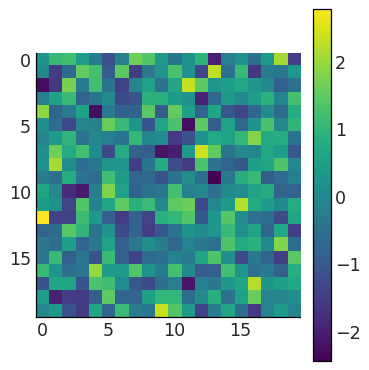

In [ ]:
plt.figure(figsize=(4,4))
imshow(z[0].reshape([20,20])); colorbar();

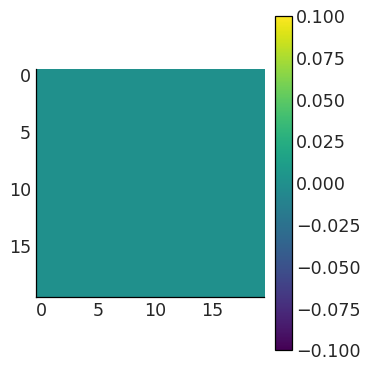

In [ ]:
plt.figure(figsize=(4,4))
imshow(zz[0].reshape([20,20])); colorbar();

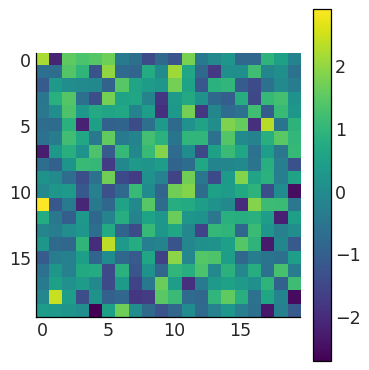

In [ ]:
plt.figure(figsize=(4,4))
imshow(zz0[0].reshape([20,20])); colorbar();

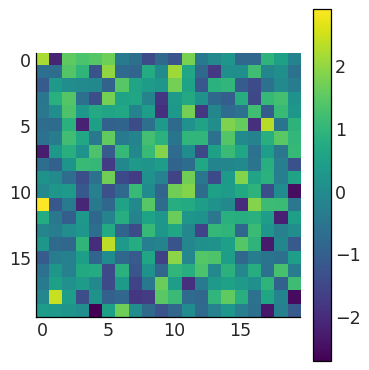

In [ ]:
plt.figure(figsize=(4,4))
imshow(ẑs[0].reshape([20,20])); colorbar();

In [ ]:
options=dict()

if z_tol is not None:
    options = dict(gtol=1e-3, **options)
if method is None:
    method = "l-bfgs-experimental-do-not-rely-on-this"

soln = minimize(
    lambda z_vec: -prob.logLike(xs[0], prob.unravel_z(z_vec), θ), 
    prob.ravel_z(ẑs[0]), 
    method = method,
    options = options
)

zMAP = prob.unravel_z(soln.x)

NameError: ignored

In [ ]:
logLike, (gradz_logLike, gradθ_logLike) = jax.value_and_grad(
      prob.logLike, 
      argnums=(1, 2)
  )(xs[0], zMAP, θ)

In [ ]:
logLike

Array(-inf, dtype=float32)

In [ ]:
gradθ_logLike
  # nan, 795623.8

Array([     nan, 795623.8], dtype=float32)

In [ ]:
plt.figure(figsize=(4,4))
imshow(xs[0]); colorbar();

In [ ]:
plt.figure(figsize=(4,4))
imshow(zMAP.reshape([20,20])); colorbar();

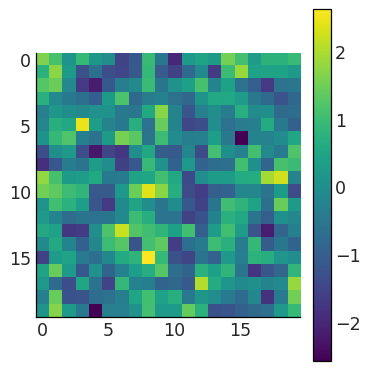

In [ ]:
plt.figure(figsize=(4,4))
imshow(simulations['z'][0].reshape([20,20])); colorbar();

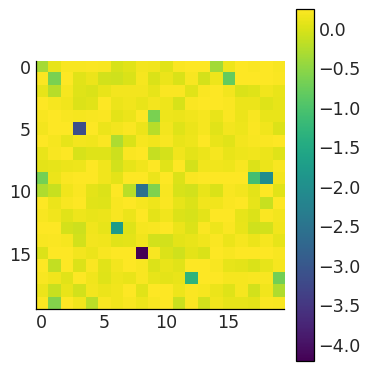

In [ ]:
plt.figure(figsize=(4,4))
imshow(zMAP.reshape([20,20]) - xs[0]); colorbar();

In [ ]:
cond_model = condition(
    model,
    {'alpha': θ[0], 'beta': θ[1], 'y': xs[0], 'z': zMAP}
)

model_trace = trace(cond_model).get_trace()

log_joint_like_y = model_trace['y']['fn'].log_prob(
    model_trace['y']['value']
)

log_joint_like_z = model_trace['z']['fn'].log_prob(
    model_trace['z']['value']
)


In [ ]:
print(log_joint_like_y)
print(log_joint_like_z)

552.1786
-479.11707


In [ ]:

  x = numpyro.sample(
      'y',
      dist.Independent(
          dist.Normal(
              field,
              PixelNoise
          ),
          2
      )
  )

In [ ]:
def val_gradz_gradθ_logLike(self, x, z, θ, transformed_θ=None):

  logLike, (gradz_logLike, gradθ_logLike) = jax.value_and_grad(prob.logLike, argnums=(1, 2))(x, z, θ)

  return (logLike, gradz_logLike, gradθ_logLike)

Array([     nan, 795623.8], dtype=float32)

In [ ]:
from collections import namedtuple


ScoreAndMAP = namedtuple("ScoreAndMAP", "s s̃ z history")

def z_MAP_and_score(self, x, z_guess, θ, method=None, options=dict(), z_tol=None, θ_tol=None):

        if z_tol is not None:
            options = dict(gtol=z_tol, **options)
        if method is None:
            method = "l-bfgs-experimental-do-not-rely-on-this"

        soln = minimize(
            lambda z_vec: -prob.logLike(x, prob.unravel_z(z_vec), θ), 
            prob.ravel_z(z_guess), 
            method = method,
            options = options
        )

        zMAP = prob.unravel_z(soln.x)

        gradθ = prob.val_gradz_gradθ_logLike(x, zMAP, θ)[2]

        return ScoreAndMAP(gradθ, gradθ, zMAP, soln)

In [ ]:
prob.z_MAP_and_score(m_data, simulations['z'][1], theta_start)

ScoreAndMAP(s=Array([ 12.877136, 151.6722  ], dtype=float32), s̃=Array([ 12.877136, 151.6722  ], dtype=float32), z=Array([ 1.6197468e+00,  9.9718922e-01, -1.9844493e-01,  6.3666880e-01,
       -6.3056290e-02, -2.2201826e-01, -9.3918186e-01, -7.2798866e-01,
        7.6096380e-01, -4.4771898e-01, -7.3237062e-01, -1.2628959e-01,
        9.6797511e-02,  7.6659851e-02,  1.6337007e+00,  8.8096416e-01,
        2.7903209e-02,  5.3995806e-01,  4.0300325e-01,  6.6287208e-01,
        5.8902371e-01,  1.8794930e+00,  1.0077840e-01, -7.6962292e-01,
       -5.4849023e-01, -9.8706692e-01, -1.0349261e+00, -8.6232847e-01,
        6.8151516e-01, -8.8885045e-01, -5.2602738e-01, -8.7299174e-01,
       -1.4246039e-01, -9.7747070e-01,  8.6988819e-01,  1.9976727e+00,
        1.9589622e-01,  1.8602546e-01,  1.8864852e-01, -6.6493109e-02,
        9.9925864e-01,  1.4754418e+00, -2.4207854e-01, -7.7061695e-01,
       -8.6952949e-01, -6.1168373e-01, -3.2036641e-01, -3.4529859e-01,
        7.4309921e-01, -6.5835494

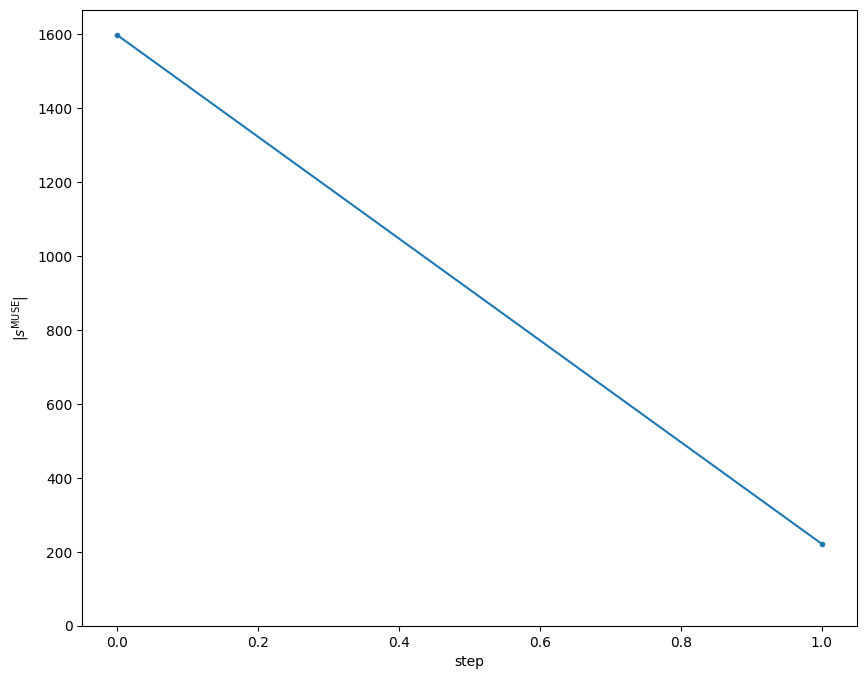

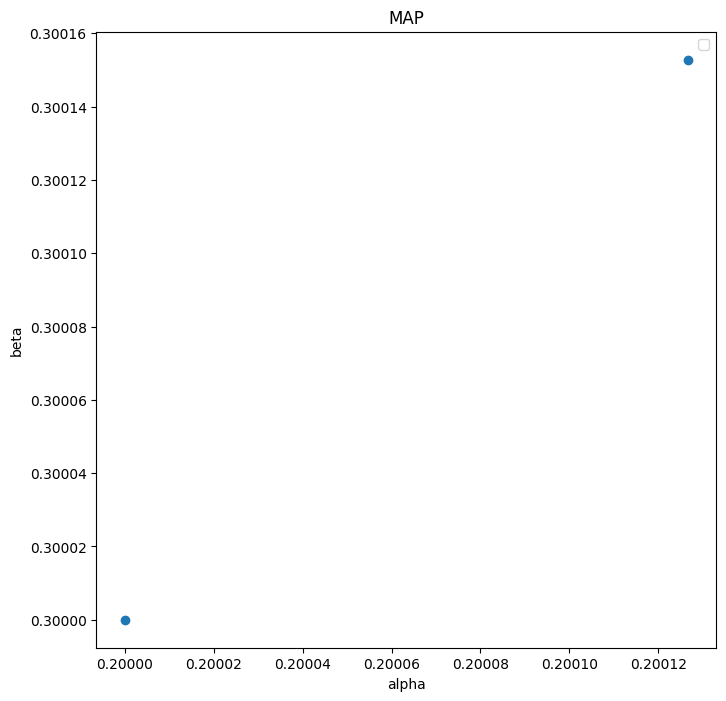

In [ ]:
plt.figure(figsize=(10, 8))
plt.plot([np.linalg.norm(h["s̃_post"]) for h in result.history], ".-")
plt.ylabel(r"$|s^{\rm MUSE}|$")
plt.xlabel("step")
plt.ylim(0)


plt.figure(figsize=(8, 8))
x, y = np.transpose([h["θ"] for h in result.history])
plt.plot(x, y, "o")
ds = 0.003
Ns = np.round(
    np.sqrt((x[1:]-x[:-1])**2 + (y[1:]-y[:-1]) ** 2) / ds
).astype(int)
subdiv = lambda x, Ns=Ns: np.concatenate([
    np.linspace(x[ii], x[ii+1], Ns[ii]) for ii, _ in enumerate(x[: -1])
])
x, y = subdiv(x), subdiv(y)
plt.quiver(
    x[:-1],
    y[:-1],
    x[1:]-x[:-1],
    y[1:]-y[:-1],
    scale_units='xy',
    angles='xy',
    scale=1,
    width=.004,
    headlength=6,
    headwidth=6
)

plt.xlabel(r"alpha")
plt.ylabel(r"beta")
plt.legend()
plt.title('MAP')

theta = result.dist.rvs(100000)

In [ ]:
# Set the seed for reproducibility
np.random.seed(10000)

In [ ]:

# # Initialize the HMC transition kernel.
# num_burnin_steps = int(3e2)
# adaptive_hmc = tfp.mcmc.SimpleStepSizeAdaptation(
#     tfp.mcmc.HamiltonianMonteCarlo(
#         target_log_prob_fn=lnL_LN,
#         num_leapfrog_steps=3,
#         step_size=0.07
#     ),
#     num_adaptation_steps=int(num_burnin_steps * 0.8))

# # Run the chain (with burn-in).
# nb_parallel = 50
# num_results = args.num_results // nb_parallel
# samples, is_accepted = tfp.mcmc.sample_chain(
#     num_results=num_results,
#     num_burnin_steps=num_burnin_steps,
#     current_state=np.random.randn(nb_parallel, 2),
#     kernel=adaptive_hmc,
#     trace_fn=lambda _, pkr: pkr.inner_results.is_accepted,
#     seed=jax.random.PRNGKey(0))
